
1. Training Q-Learning Agent...


Training: 100%|██████████| 1000000/1000000 [02:29<00:00, 6678.64it/s]


✓ Training completato
  Stati Q-table: 280
Win Rate:  0.4033
Loss Rate: 0.5095
Draw Rate: 0.0872


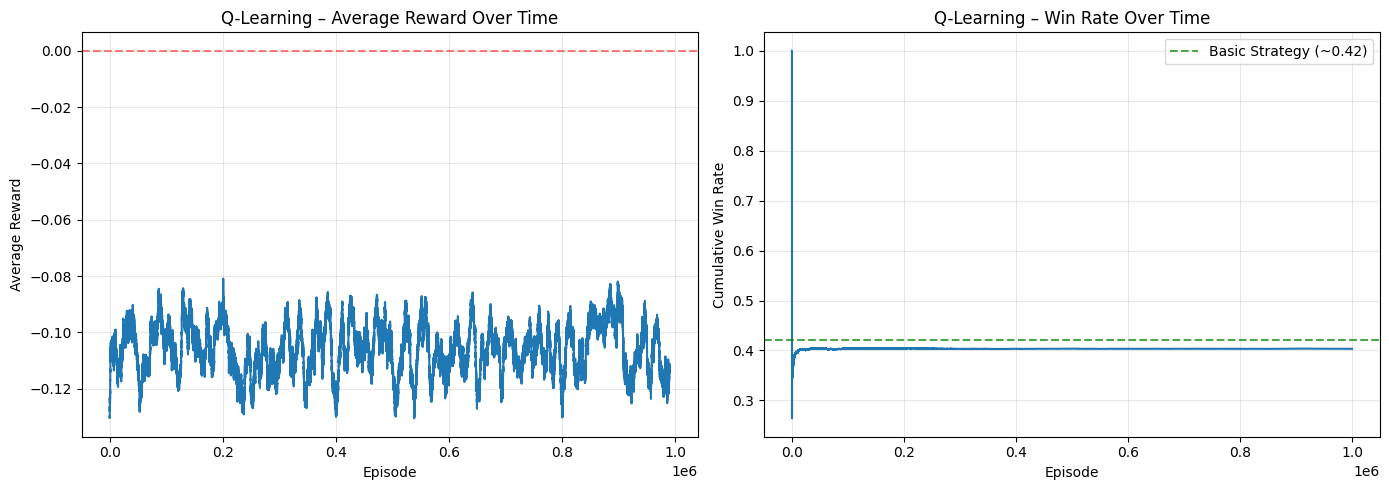

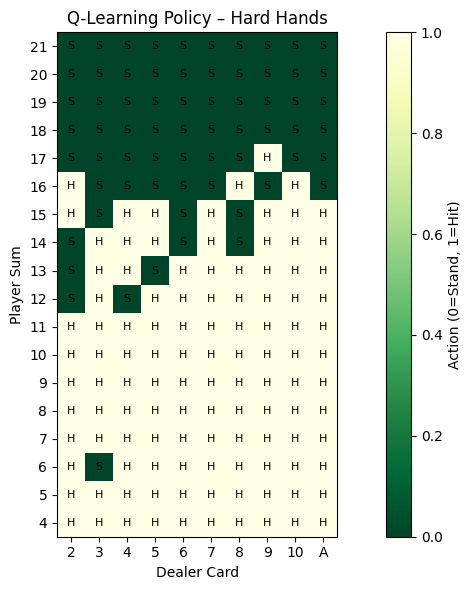

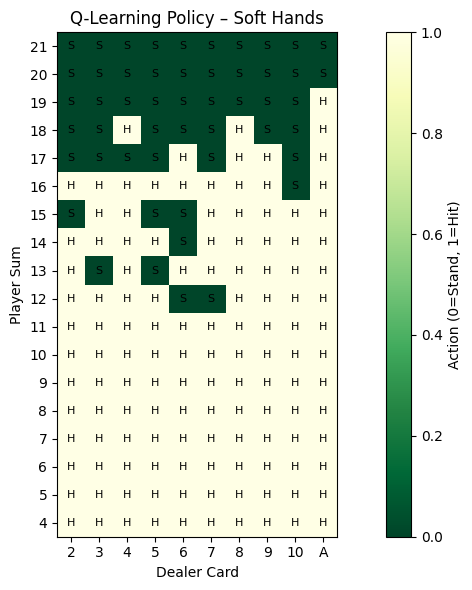

In [2]:

# Q-LEARNING ONLINE – BLACKJACK

from collections import defaultdict
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

# BLACKJACK ENVIRONMENT

class BlackjackEnv:
    def __init__(self):
        self.deck = self._create_deck()

    def _create_deck(self):
        ranks = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
        return ranks * 4 * 6  # 6 mazzi

    def _card_value(self, card):
        if card in ['J','Q','K']:
            return 10
        if card == 'A':
            return 11
        return int(card)

    def _hand_value(self, hand):
        value = sum(self._card_value(c) for c in hand)
        aces = hand.count('A')
        while value > 21 and aces > 0:
            value -= 10
            aces -= 1
        return value

    def reset(self):
        self.deck = self._create_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self._get_state()

    def _get_state(self):
        player_sum = self._hand_value(self.player_hand)
        dealer_up = self._card_value(self.dealer_hand[0])
        usable_ace = 'A' in self.player_hand and player_sum <= 21
        return (player_sum, dealer_up, usable_ace)

    def step(self, action):
        # action: 0 = STAND, 1 = HIT
        if action == 1:
            if not self.deck:
                self.deck = self._create_deck()
                random.shuffle(self.deck)

            self.player_hand.append(self.deck.pop())
            player_sum = self._hand_value(self.player_hand)
            if player_sum > 21:
                return self._get_state(), -1, True
            return self._get_state(), 0, False

        # STAND
        while self._hand_value(self.dealer_hand) < 17:
            if not self.deck:
                self.deck = self._create_deck()
                random.shuffle(self.deck)
            self.dealer_hand.append(self.deck.pop())

        player_sum = self._hand_value(self.player_hand)
        dealer_sum = self._hand_value(self.dealer_hand)

        if dealer_sum > 21 or player_sum > dealer_sum:
            reward = 1
        elif player_sum == dealer_sum:
            reward = 0
        else:
            reward = -1

        return self._get_state(), reward, True


# Q-LEARNING AGENT

class QLearningAgent:
    def __init__(self, epsilon=0.1, alpha=0.1, gamma=0.9):
        self.Q = defaultdict(lambda: [0.0, 0.0])  # [STAND, HIT]
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.episode_rewards = []
        self.wins = 0
        self.losses = 0
        self.draws = 0

    def get_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.choice([0, 1])
        return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state, done):
        current_q = self.Q[state][action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * max(self.Q[next_state])
        self.Q[state][action] = current_q + self.alpha * (target - current_q)


# TRAINING

print("\n1. Training Q-Learning Agent...")

env = BlackjackEnv()
agent = QLearningAgent(epsilon=0.1, alpha=0.1, gamma=0.9)

n_episodes = 1_000_000

for _ in tqdm(range(n_episodes), desc="Training"):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.get_action(state, training=True)
        next_state, reward, done = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        episode_reward = reward

    agent.episode_rewards.append(episode_reward)
    if episode_reward > 0:
        agent.wins += 1
    elif episode_reward < 0:
        agent.losses += 1
    else:
        agent.draws += 1

print("✓ Training completato")
print(f"  Stati Q-table: {len(agent.Q)}")

win_rate = agent.wins / n_episodes
loss_rate = agent.losses / n_episodes
draw_rate = agent.draws / n_episodes

print(f"Win Rate:  {win_rate:.4f}")
print(f"Loss Rate: {loss_rate:.4f}")
print(f"Draw Rate: {draw_rate:.4f}")


# LEARNING CURVE

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

window = 10_000
rewards_smooth = np.convolve(
    agent.episode_rewards,
    np.ones(window)/window,
    mode='valid'
)

axes[0].plot(rewards_smooth)
axes[0].set_title("Q-Learning – Average Reward Over Time")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Average Reward")
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

wins_cumulative = np.cumsum([1 if r > 0 else 0 for r in agent.episode_rewards])
episodes = np.arange(1, len(agent.episode_rewards) + 1)
win_rates = wins_cumulative / episodes

axes[1].plot(win_rates)
axes[1].set_title("Q-Learning – Win Rate Over Time")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Cumulative Win Rate")
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.42, color='g', linestyle='--',
                label='Basic Strategy (~0.42)', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.savefig("QLearningResults.png", dpi=150, bbox_inches="tight")
plt.show()

# POLICY EXTRACTION (HEATMAP)

def best_action(Q, state):
    if state not in Q:
        return 1  # HIT default
    return np.argmax(Q[state])  # 0=STAND, 1=HIT


player_sums = range(4, 22)
dealer_cards = range(2, 12)  # 2–10, A=11

hard_policy = np.zeros((len(player_sums), len(dealer_cards)))
soft_policy = np.zeros_like(hard_policy)

for i, ps in enumerate(player_sums):
    for j, dc in enumerate(dealer_cards):
        hard_policy[i, j] = best_action(agent.Q, (ps, dc, False))
        soft_policy[i, j] = best_action(agent.Q, (ps, dc, True))


def plot_policy(matrix, title, filename):
    plt.figure(figsize=(10, 6))
    plt.imshow(matrix, cmap="YlGn_r", origin="lower")

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            action = "S" if matrix[i, j] == 0 else "H"
            plt.text(j, i, action, ha="center", va="center",
                     color="black", fontsize=8)

    plt.xticks(range(len(dealer_cards)),
               ['2','3','4','5','6','7','8','9','10','A'])
    plt.yticks(range(len(player_sums)), player_sums)

    plt.xlabel("Dealer Card")
    plt.ylabel("Player Sum")
    plt.title(title)
    plt.colorbar(label="Action (0=Stand, 1=Hit)")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


plot_policy(hard_policy,
            "Q-Learning Policy – Hard Hands",
            "QLearningPolicyHard.png")

plot_policy(soft_policy,
            "Q-Learning Policy – Soft Hands",
            "QLearningPolicySoft.png")
